<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/linear_deep_learning_negative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs latest version of TensorFlow 2.X 
# !pip install --upgrade tensorflow

In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import datetime
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import tensorflow as tf

In [2]:
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http

In [3]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

# Exploring the taken data

In [5]:
# Convert DataFrame to Pandas
joined_data_df = text_df.toPandas()
print(joined_data_df.shape)
joined_data_df.head(5)

(713009, 22)


,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


In [6]:
# Change the dtypes of tweetcreatedts
joined_data_df["tweetcreatedts"] = pd.to_datetime(joined_data_df["tweetcreatedts"])
print (joined_data_df["tweetcreatedts"])

0        2022-02-26
1        2022-02-26
2        2022-02-26
3        2022-02-26
4        2022-02-26
            ...    
713004   2022-02-26
713005   2022-02-26
713006   2022-02-26
713007   2022-02-26
713008          NaT
Name: tweetcreatedts, Length: 713009, dtype: datetime64[ns]


In [8]:
# drop the row with any NaT values in the tweetcreatedts column
joined_data_df = joined_data_df.dropna(axis=0, subset=['tweetcreatedts']) 
joined_data_df.shape

(713008, 22)

# Explore the data if nothing lost

In [9]:
earliest_tweet = joined_data_df["tweetcreatedts"].min()
latest_tweet = joined_data_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-24 00:00:00, and the latest was at 2022-08-18 00:00:00


In [10]:
joined_data_df["tweetcreatedts"] = joined_data_df["tweetcreatedts"].dt.date
print (joined_data_df["tweetcreatedts"])

0         2022-02-26
1         2022-02-26
2         2022-02-26
3         2022-02-26
4         2022-02-26
             ...    
713003    2022-02-26
713004    2022-02-26
713005    2022-02-26
713006    2022-02-26
713007    2022-02-26
Name: tweetcreatedts, Length: 713008, dtype: object


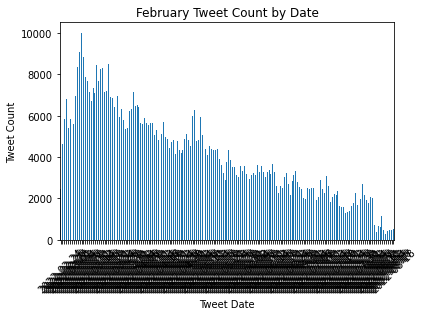

In [11]:
from pandas.core.arrays.datetimelike import DatetimeLikeScalar
from numpy.core.multiarray import datetime_as_string
#Get the plot of tweet count by date 
dates = joined_data_df["tweetcreatedts"]

# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = joined_data_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("February Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()

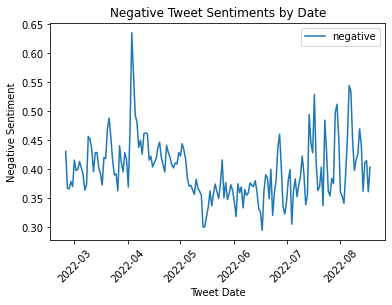

In [12]:
#Get the plot of negative score by date of tweet
negative_df = joined_data_df[['tweetcreatedts', 'negative']]

negative_by_date = negative_df.groupby([negative_df['tweetcreatedts']]).mean()

# plot bar graph of tweet count by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()


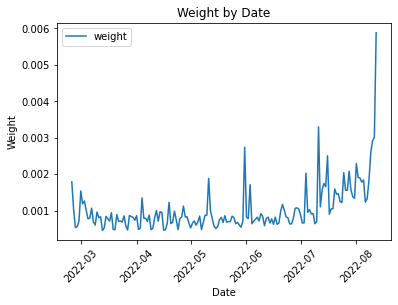

In [13]:
#Get the plot of day weight by date
joined_data_df.plot.line(x='tweetcreatedts', y='weight');

plt.title("Weight by Date")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Cleaning data

In [14]:
# Drop the not needed column
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_result", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("date_published", axis=1, inplace=True)

In [15]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713008 non-null  int32  
 1   following        713008 non-null  float64
 2   followers        713008 non-null  float64
 3   totaltweets      713008 non-null  float64
 4   tweetcreatedts   713008 non-null  object 
 5   hashtags         713008 non-null  object 
 6   is_retweet       344456 non-null  object 
 7   is_quote_status  344456 non-null  object 
 8   weight           710366 non-null  float64
 9   cleaned_text     712997 non-null  object 
 10  negative         713008 non-null  float64
dtypes: float64(5), int32(1), object(5)
memory usage: 78.7+ MB


# Categorical valuables

In [16]:
# Convert datetime to float

# time_df["tweetcreatedts"] = pd.to_numeric(joined_data_df.index, downcast='float')

joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(str)
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].str.replace('-', '')
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(float)
print(joined_data_df["tweetcreatedts"])

0         20220226.0
1         20220226.0
2         20220226.0
3         20220226.0
4         20220226.0
             ...    
713003    20220226.0
713004    20220226.0
713005    20220226.0
713006    20220226.0
713007    20220226.0
Name: tweetcreatedts, Length: 713008, dtype: float64


In [17]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [19]:
# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
joined_data_df["is_retweet"] = joined_data_df['is_retweet'].astype(bool)
joined_data_df["is_quote_status"] = joined_data_df['is_quote_status'].astype(bool)
# Replace boolean columns
joined_data_df['is_retweet'] = joined_data_df['is_retweet'].astype(int)
joined_data_df['is_quote_status'] = joined_data_df['is_quote_status'].astype(int)
joined_data_df.head()

,_c0,following,followers,totaltweets,tweetcreatedts,hashtags,is_retweet,is_quote_status,weight,negative,text_length
0,0,1893.0,417389.0,335685.0,20220226.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",0,0,0.000533,0.222473,77.0
1,1,64.0,254.0,110.0,20220226.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",0,0,0.000533,0.078324,40.0
2,2,5766.0,5329.0,119448.0,20220226.0,[],0,0,0.000533,0.147500,138.0
3,3,294.0,172.0,15270.0,20220226.0,[],0,0,0.000533,0.883955,220.0
4,4,975.0,75.0,1988.0,20220226.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",0,0,0.000533,0.063437,16.0


In [20]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713008 non-null  int32  
 1   following        713008 non-null  float64
 2   followers        713008 non-null  float64
 3   totaltweets      713008 non-null  float64
 4   tweetcreatedts   713008 non-null  float64
 5   hashtags         713008 non-null  object 
 6   is_retweet       713008 non-null  int64  
 7   is_quote_status  713008 non-null  int64  
 8   weight           710366 non-null  float64
 9   negative         713008 non-null  float64
 10  text_length      712997 non-null  float64
dtypes: float64(7), int32(1), int64(2), object(1)
memory usage: 78.7+ MB


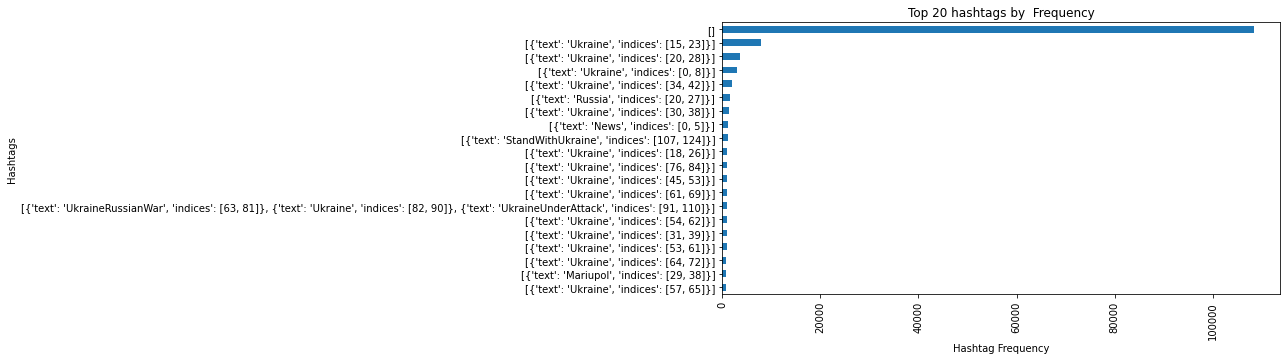

In [21]:
# Find the top 20 hashtags by frequency
plt.figure(figsize=(10,5))
joined_data_df["hashtags"].value_counts().sort_values(ascending=True)[-20:].plot.barh();
plt.title("Top 20 hashtags by  Frequency")
plt.xlabel("Hashtag Frequency")
plt.ylabel("Hashtags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
plt.show()

In [22]:
# Generate our categorical variable list
cat_var = joined_data_df.dtypes[joined_data_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
joined_data_df[cat_var].nunique()

hashtags    228957
dtype: int64

In [23]:
print (joined_data_df[cat_var])

                                                 hashtags
0       [{'text': 'UkraineCrisis', 'indices': [102, 11...
1       [{'text': 'StandWithUkriane', 'indices': [58, ...
2                                                      []
3                                                      []
4       [{'text': 'KyivDefiant', 'indices': [18, 30]},...
...                                                   ...
713003           [{'text': 'Putin', 'indices': [41, 47]}]
713004          [{'text': 'Russia', 'indices': [25, 32]}]
713005  [{'text': 'Ukraine', 'indices': [26, 34]}, {'t...
713006  [{'text': 'EU', 'indices': [20, 23]}, {'text':...
713007       [{'text': 'Ukraine', 'indices': [112, 120]}]

[713008 rows x 1 columns]


### There is too much hashtags for creating a OneHotEncoder instance

Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(joined_data_df[cat_var]))

Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_var)
encode_df.head()

In [24]:
# Drop the hashtags column
joined_data_df.drop("hashtags", axis=1, inplace=True)

In [25]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713008 non-null  int32  
 1   following        713008 non-null  float64
 2   followers        713008 non-null  float64
 3   totaltweets      713008 non-null  float64
 4   tweetcreatedts   713008 non-null  float64
 5   is_retweet       713008 non-null  int64  
 6   is_quote_status  713008 non-null  int64  
 7   weight           710366 non-null  float64
 8   negative         713008 non-null  float64
 9   text_length      712997 non-null  float64
dtypes: float64(7), int32(1), int64(2)
memory usage: 73.2 MB


In [26]:
# get the shape of the new DataFrame
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

713008 rows and 10 columns


In [27]:
negative_df = joined_data_df[['tweetcreatedts', 'negative']]
negative_df.head(5)

,tweetcreatedts,negative
0,20220226.0,0.222473
1,20220226.0,0.078324
2,20220226.0,0.147500
3,20220226.0,0.883955
4,20220226.0,0.063437


In [28]:
# Drop the null rows
joined_data_df = joined_data_df.dropna()
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

710355 rows and 10 columns


In [29]:
negative_df = joined_data_df[['tweetcreatedts', 'negative']]
negative_df.head(5)

,tweetcreatedts,negative
0,20220226.0,0.222473
1,20220226.0,0.078324
2,20220226.0,0.147500
3,20220226.0,0.883955
4,20220226.0,0.063437


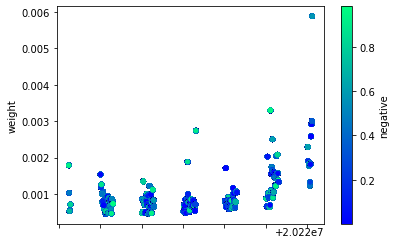

In [32]:
# Plotting the data
joined_data_df.plot.scatter(x="tweetcreatedts", y="weight", c="negative", colormap="winter")

# Standartization Data

In [33]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(joined_data_df)

# Scale the data
scaled_data = scaler.transform(joined_data_df)

# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, columns=joined_data_df.columns)
transformed_scaled_data.head(5)

,_c0,following,followers,totaltweets,tweetcreatedts,is_retweet,is_quote_status,weight,negative,text_length
0,-1.730995,-0.177340,0.689392,1.330729,-1.578197,-0.645473,-0.222816,-0.78303,-0.542880,-0.925411
1,-1.730990,-0.298441,-0.101081,-0.678497,-1.578197,-0.645473,-0.222816,-0.78303,-0.974009,-1.446835
2,-1.730985,0.079098,-0.091464,0.036029,-1.578197,-0.645473,-0.222816,-0.78303,-0.767114,-0.065765
3,-1.730980,-0.283213,-0.101236,-0.587728,-1.578197,-0.645473,-0.222816,-0.78303,1.435525,1.089825
4,-1.730975,-0.238122,-0.101420,-0.667253,-1.578197,-0.645473,-0.222816,-0.78303,-1.018536,-1.785056


#  What does the distribution look like

In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the Probability Density Function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination.

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f426a963090> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


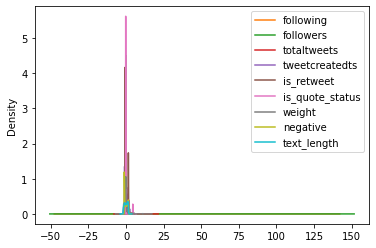

In [34]:
# Generate Kernel Density Estimate plot using Gaussian kernels, using the Density method to fing out

ax = transformed_scaled_data.plot.kde()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f426c10d110> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


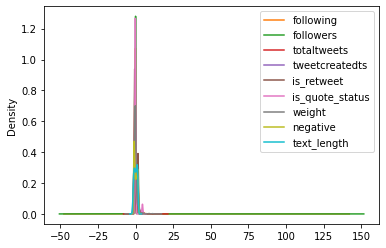

In [35]:
# Using a small bandwidth value 
ax = transformed_scaled_data.plot.kde(bw_method=0.3)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f426d1746d0> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


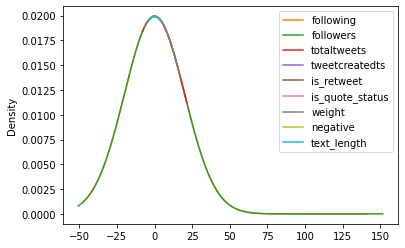

In [36]:
# Using a large bandwidt value
ax = transformed_scaled_data.plot.kde(bw_method=20)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f426e1d3650> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


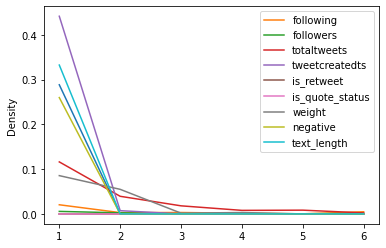

In [37]:
# Determine the evaluation points for the plot of the estimated PDF
ax = transformed_scaled_data.plot.kde(ind=[1, 2, 3, 4, 5, 6])

# Use Deep Learning Model

In [38]:
# Split our preprocessed data into our features and target arrays
y = transformed_scaled_data["negative"].values
X = transformed_scaled_data.drop(["negative"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [40]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile the model
# tf.keras.losses.MeanAbsolutePercentageError(
#    reduction="auto", name="mean_absolute_percentage_error")
	
nn.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
#nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
# Fit the model to the training data
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)
# fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
16649/16649 [==============================] - 32s 2ms/step - loss: 0.9357 - accuracy: 0.0000e+00
Epoch 2/100
16649/16649 [==============================] - 31s 2ms/step - loss: 0.9208 - accuracy: 0.0000e+00
Epoch 3/100
16649/16649 [==============================] - 29s 2ms/step - loss: 0.9187 - accuracy: 0.0000e+00
Epoch 4/100
16649/16649 [==============================] - 29s 2ms/step - loss: 0.9174 - accuracy: 0.0000e+00
Epoch 5/100
16649/16649 [==============================] - 31s 2ms/step - loss: 0.9168 - accuracy: 0.0000e+00
Epoch 6/100
16649/16649 [==============================] - 29s 2ms/step - loss: 0.9163 - accuracy: 0.0000e+00
Epoch 7/100
16649/16649 [==============================] - 29s 2ms/step - loss: 0.9158 - accuracy: 0.0000e+00
Epoch 8/100
16649/16649 [==============================] - 30s 2ms/step - loss: 0.9157 - accuracy: 0.0000e+00
Epoch 9/100
16649/16649 [==============================] - 30s 2ms/step - loss: 0.9155 - accuracy: 0.0000e+00
Epoch 10/1

In [43]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5550/5550 - 6s - loss: 0.9082 - accuracy: 0.0000e+00 - 6s/epoch - 1ms/step
Loss: 0.9082058072090149, Accuracy: 0.0


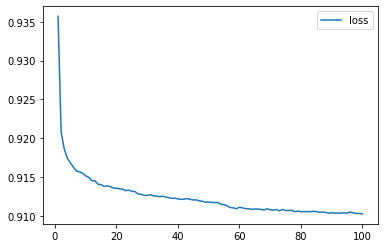

In [44]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

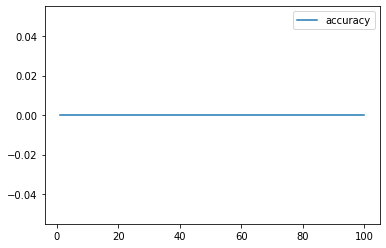

In [45]:
# Plot the accuracy
history_df.plot(y="accuracy")